Compute EEG residuals from learned encoders, dropping out relevant word-level features (surprisal and frequency).

For word stimuli with matched cohorts (or at least matched likelihoods), find instances which are recognized early vs. late due to context.
Bin and compare residual time series between bins.

In [1]:
from argparse import ArgumentParser, Namespace
from collections import defaultdict
from copy import deepcopy
from itertools import product
from pathlib import Path
import pickle
import sys

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import clone
import torch
from tqdm.auto import tqdm, trange

In [2]:
from IPython.display import HTML

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append(str(Path(".").resolve().parent.parent))
from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.eeg import load_eeg_dataset
import berp.models.reindexing_regression as rr

In [5]:
IS_INTERACTIVE = False
try:
    get_ipython()  # type: ignore
except NameError: pass
else: IS_INTERACTIVE = True
IS_INTERACTIVE

True

In [6]:
p = ArgumentParser()
p.add_argument("model_base_dir", type=Path, nargs="+")
p.add_argument("subjects", type=str, nargs="+")
p.add_argument("stories", type=str, nargs="+")
p.add_argument("run_names", type=str, nargs="+")

_StoreAction(option_strings=[], dest='run_names', nargs='+', const=None, default=None, type=<class 'str'>, choices=None, required=True, help=None, metavar=None)

In [7]:
if IS_INTERACTIVE:
    args = Namespace(model_base_dir=Path("../../work/2b/cda8e6c76a9235517148309c3afb33"),
                     subjects=["2019_C2DNN_29"],
                     stories=["DKZ_1", "DKZ_2"],
                     run_names=["berp-fixed3"],)
else:
    args = p.parse_args()

## Load results

In [8]:
# Load pipelines.
if len(args.run_names) > 1:
    raise NotImplementedError("not yet supporting multiple pipelines")

pipes = []
for run in args.run_names:
    pipeline_path = args.model_base_dir / run / "params" / "pipeline.pkl"
    if not pipeline_path.exists():
        print(f"Missing pipeline at {pipeline_path}")

    with pipeline_path.open("rb") as f:
        pipes.append(pickle.load(f))
        
    # TODO shape checks etc.

# TODO support more than one pipeline
pipe = pipes[0]

In [9]:
# Load datasets.
target_sensors = ["C1", "Cz", "C2", "CP1", "CPz", "CP2"]
ds = []
combs = list(product(args.stories, args.subjects))
for story, subject in tqdm(combs):
    ds_path = args.model_base_dir / f"{story}.{subject}.pkl"
    if not ds_path.exists():
        print(f"Could not find dataset {ds_path}")
        continue

    # Avoid NestedBerpDataset splits by passing paths individually
    ds.append(load_eeg_dataset(
        [ds_path], "biosemi64", subset_sensors=target_sensors,
        normalize_X_ts=True, normalize_X_variable=True, normalize_Y=True).datasets[0])

  0%|          | 0/2 [00:00<?, ?it/s]

## Preprocessing

In [10]:
if len(args.subjects) > 1:
    raise NotImplementedError()

encoder = pipe.encoders_[args.subjects[0]]

In [11]:
feature_names = ds[0].ts_feature_names + ds[0].variable_feature_names
feature_names

['binned acoustical edges >100Hz_0',
 'binned acoustical edges >100Hz_1',
 'binned acoustical edges >100Hz_2',
 'binned acoustical edges >100Hz_3',
 'binned acoustical edges >100Hz_4',
 'binned acoustical edges >100Hz_5',
 'binned acoustical edges >100Hz_6',
 'binned acoustical edges >100Hz_7',
 'phoneme onsets_0',
 'binned spectrogram >100Hz_0',
 'binned spectrogram >100Hz_1',
 'binned spectrogram >100Hz_2',
 'binned spectrogram >100Hz_3',
 'binned spectrogram >100Hz_4',
 'binned spectrogram >100Hz_5',
 'binned spectrogram >100Hz_6',
 'binned spectrogram >100Hz_7',
 'word onsets_0',
 'word_frequency',
 'word_surprisal']

In [13]:
encoder.n_delays_

73

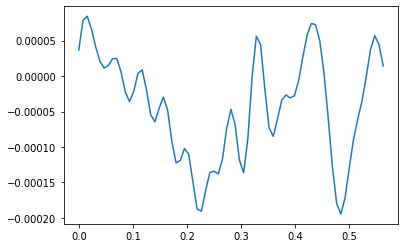

In [14]:
def plot_coefs(feature_name):
    xs = np.linspace(encoder.tmin, encoder.tmax, encoder.n_delays_)
    ys = encoder.coef_[feature_names.index(feature_name), :].mean(axis=1)
    plt.plot(xs, ys)
plot_coefs("word_surprisal")

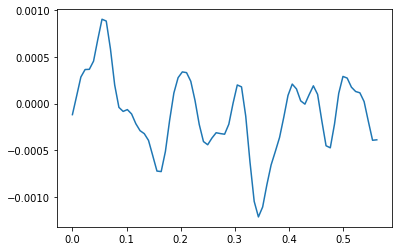

In [15]:
plot_coefs("phoneme onsets_0")

In [16]:
params = pipe.params[0]

p_candidates, recognition_points = {}, {}
for ds_i in tqdm(ds):
    p_candidates[ds_i.name] = rr.predictive_model(
        ds_i.p_word, ds_i.candidate_phonemes,
        confusion=params.confusion,
        lambda_=params.lambda_,
        return_gt_only=False)
    recognition_points[ds_i.name] = rr.recognition_point_model(
        p_candidates[ds_i.name][:, 0, :], ds_i.word_lengths, params.threshold)

  0%|          | 0/2 [00:00<?, ?it/s]

## Compute residual time series

In [18]:
ablated_encoder = deepcopy(encoder)
# Zero out variable-onset features.
variable_onset_feature_start = ds[0].n_ts_features
ablated_encoder.coef_[variable_onset_feature_start:, :, :] = 0.

In [19]:
Y_resid, Y_resid_ablated = {}, {}
for ds_i in tqdm(ds):
    pipe.prime(ds_i)
    
    design_matrix, _ = pipe.pre_transform(ds_i)
    Y_pred = encoder.predict(design_matrix)
    Y_pred_ablated = ablated_encoder.predict(design_matrix)
    
    Y_resid[ds_i.name] = ds_i.Y - Y_pred
    Y_resid_ablated[ds_i.name] = ds_i.Y - Y_pred_ablated
    
    mse = (Y_resid[ds_i.name] ** 2).sum(axis=1).mean()
    mse_ablated = (Y_resid_ablated[ds_i.name] ** 2).sum(axis=1).mean()
    print(ds_i.name, mse, mse_ablated, mse - mse_ablated)

  0%|          | 0/2 [00:00<?, ?it/s]

DKZ_1/2019_C2DNN_29 tensor(5.9733) tensor(5.9734) tensor(-4.6253e-05)
DKZ_2/2019_C2DNN_29 tensor(5.9779) tensor(5.9779) tensor(-4.3869e-05)


In [20]:
# # Comparison case: what happens when we ablate word onset feature?
# feature_names = ds.ts_feature_names + ds.variable_feature_names
# ablated_encoder2 = deepcopy(encoder)
# ablated_encoder2.coef_[feature_names.index("word onsets_0"), :, :] = 0.

# Y_pred_ablated2 = ablated_encoder2.predict(design_matrix)
# Y_resid_ablated2 = ds.Y - Y_pred_ablated2
# mse_ablated2 = (Y_resid_ablated2 ** 2).sum(axis=1).mean()
# mse_ablated2, mse - mse_ablated2

## Stimulus search

Find words with matched cohorts.

In [254]:
gt_word_strs = ["".join(ds.phonemes[phon_idx] for phon_idx in gt_phonemes).rstrip("_")
                for gt_phonemes in tqdm(ds.candidate_phonemes[:, 0, :])]

  0%|          | 0/2118 [00:00<?, ?it/s]

In [255]:
words_by_cohort = {}
word_ids_by_cohort = {}
for n_phonemes in trange(2, 5):
    words_by_cohort[n_phonemes] = defaultdict(set)
    word_ids_by_cohort[n_phonemes] = defaultdict(list)
    for idx, gt_str in enumerate(gt_word_strs):
        if len(gt_str) < n_phonemes: continue
        
        words_by_cohort[n_phonemes][gt_str[:n_phonemes]].add(gt_str)
        word_ids_by_cohort[n_phonemes][gt_str[:n_phonemes]].append(idx)

  0%|          | 0/3 [00:00<?, ?it/s]

In [256]:
# Find most frequent cohorts.
cohort_sizes = {cohort_length: {cohort: len(word_idxs) for cohort, word_idxs in cohorts.items()}
                for cohort_length, cohorts in word_ids_by_cohort.items()}

k = 10
{length: [(cohort, size) for cohort, size in sorted(cohorts.items(), key=lambda v: -v[1])[:k]]
 for length, cohorts in cohort_sizes.items()}

{2: [('də', 104),
  ('#d', 71),
  ('zə', 60),
  ('#ɛ', 56),
  ('ət', 41),
  ('vɑ', 40),
  ('#z', 39),
  ('ɛn', 36),
  ('ha', 36),
  ('ze', 35)],
 3: [('#ɛn', 48),
  ('har', 35),
  ('vɑn', 35),
  ('#də', 25),
  ('zɛi', 24),
  ('nit', 23),
  ('#dɑ', 22),
  ('mɛn', 18),
  ('dɑt', 17),
  ('#zə', 16)],
 4: [('mɛns', 18),
  ('zeme', 14),
  ('zɛin', 14),
  ('prɪn', 13),
  ('#mar', 13),
  ('#dɑt', 11),
  ('hɛbə', 11),
  ('klɛi', 10),
  ('watə', 9),
  ('#zɛi', 9)]}

In [257]:
# Find cohorts with greatest number of word-type completions.
cohort_uniq_sizes = {cohort_length: {cohort: len(words) for cohort, words in cohorts.items()}
                     for cohort_length, cohorts in words_by_cohort.items()}

k = 10
{length: [(cohort, size) for cohort, size in sorted(cohorts.items(), key=lambda v: -v[1])[:k]]
 for length, cohorts in cohort_uniq_sizes.items()}

{2: [('xə', 30),
  ('st', 22),
  ('#w', 21),
  ('#d', 19),
  ('hɛ', 18),
  ('ze', 17),
  ('#z', 16),
  ('sx', 15),
  ('#ɑ', 15),
  ('xr', 14)],
 3: [('vər', 13),
  ('har', 10),
  ('zɛi', 9),
  ('#ɑl', 8),
  ('zem', 7),
  ('nit', 7),
  ('dar', 7),
  ('mɛn', 6),
  ('#dɑ', 6),
  ('stɛ', 6)],
 4: [('zeme', 6),
  ('mɛns', 6),
  ('#dar', 5),
  ('vɪsə', 5),
  ('krɛi', 5),
  ('prɪn', 4),
  ('#mar', 4),
  ('hɛbə', 4),
  ('#ɑlə', 4),
  ('vɑst', 4)]}

In [258]:
COHORT_SELECTION = "moj"
cohort_word_ids = word_ids_by_cohort[len(COHORT_SELECTION)][COHORT_SELECTION]
cohort_word_ids

[241, 806, 896, 969, 995, 1163, 1176, 1199, 1225, 1773, 1883, 1908, 2067]

## Visualize epoched data

In [21]:
def make_word_epochs(word_idxs, word_onsets, phoneme_onsets, recognition_points, eeg_data,
                     index_by_recognition=False, baseline=True):
    tmin, tmax = -12/128, 96/128
    baseline_window = (-12/128, 0.0)
    # DEV for now assume things cut cleanly w.r.t. sample rate
    sample_rate = ds[0].sample_rate
    assert int(tmin * sample_rate) == tmin * sample_rate
    assert int(tmax * sample_rate) == tmax * sample_rate
    for edge in baseline_window:
        assert int(edge * sample_rate) == edge * sample_rate
    epoch_n_samples = int((tmax - tmin) * sample_rate)
    # Compute baseline sample indices relative to start of epoch window
    baseline_samp_window = (int((baseline_window[0] - tmin) * sample_rate),
                            int((baseline_window[1] - tmin) * sample_rate))

    if index_by_recognition:
        # t=0 <=> recognition point
        relative_rec_onset = torch.gather(phoneme_onsets, 1, recognition_points.unsqueeze(1)).squeeze()
        onsets = word_onsets[word_idxs] + relative_rec_onset
    else:
        # t=0 <=> word onset (first phoneme onset)
        onsets = word_onsets[word_idxs]
    onsets_samp = (onsets * sample_rate).long()
    
    epoch_shift_left = int(tmin * sample_rate)
    epoch_shift_right = int(tmax * sample_rate)

    # Epoch EEG data.
    epochs = np.empty((len(word_idxs), epoch_n_samples, len(target_sensors)))
    for i, samp_i in enumerate(tqdm(onsets_samp)):
        epoch_data = eeg_data[samp_i + epoch_shift_left:samp_i + epoch_shift_right]

        # Baseline
        if baseline:
            baseline_left, baseline_right = baseline_samp_window
            epoch_data -= epoch_data[baseline_left:baseline_right].mean(axis=0)
        
        if epoch_data.shape[0] < epoch_n_samples:
            # pad with NaNs
            epoch_data = np.concatenate(
                [epoch_data,
                 np.empty((epoch_n_samples - epoch_data.shape[0], len(target_sensors))) * np.nan],
                axis=0)

        epochs[i] = epoch_data
        
    # Get word recognition points for each target word token.
    our_recognition_points = recognition_points[word_idxs].numpy()

    # Convert to DataFrame.
    epochs_df = []
    for i, sample, sensor in np.ndindex(*epochs.shape):
        epochs_df.append((i, sample, target_sensors[sensor], epochs[i, sample, sensor], our_recognition_points[i]))
    epochs_df = pd.DataFrame(epochs_df, columns=["epoch", "sample", "sensor", "value", "recognition_point"])
    epochs_df["epoch_time"] = epochs_df["sample"] / sample_rate + tmin
    epochs_df = epochs_df.set_index(["epoch", "sample", "sensor"])
    
    return epochs_df

In [22]:
# cohort_epochs = make_word_epochs(cohort_word_ids, Y_resid_ablated)

# plt.subplots(figsize=(10, 10))
# sns.lineplot(data=cohort_epochs.reset_index(), x="epoch_time", y="value", hue="recognition_point", ci=None)
# plt.axvline(0)

## Epoch by recognition point

In [23]:
rec_epoch_dfs = {}
for recognition_point in tqdm([0, 1, 2, 3]):
    for ds_name, recognition_points_ds in recognition_points.items():
        word_ids = torch.where(recognition_points_ds == recognition_point)[0]
        ds_i = next(iter(d for d in ds if d.name == ds_name))
        eeg_data = Y_resid_ablated[ds_name]
        
        rec_epoch_dfs[(ds_name, recognition_point)] = make_word_epochs(
            word_ids, ds_i.word_onsets, ds_i.phoneme_onsets,
            recognition_points_ds, eeg_data)

        print(recognition_point, len(rec_epoch_dfs[(ds_name, recognition_point)]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/953 [00:00<?, ?it/s]

0 617544


  0%|          | 0/884 [00:00<?, ?it/s]

0 572832


  0%|          | 0/705 [00:00<?, ?it/s]

1 456840


  0%|          | 0/694 [00:00<?, ?it/s]

1 449712


  0%|          | 0/371 [00:00<?, ?it/s]

2 240408


  0%|          | 0/358 [00:00<?, ?it/s]

2 231984


  0%|          | 0/118 [00:00<?, ?it/s]

3 76464


  0%|          | 0/135 [00:00<?, ?it/s]

3 87480


In [24]:
rec_epoch_df_all = pd.concat(rec_epoch_dfs, names=["dataset_name", "rec_point", "epoch", "sample", "sensor"])
rec_epoch_df_all

value  \
dataset_name        rec_point epoch sample sensor             
DKZ_1/2019_C2DNN_29 0         0     0      C1     -0.992882   
                                           Cz     -0.444416   
                                           C2     -0.529587   
                                           CP1    -1.328678   
                                           CPz    -0.918937   
...                                                     ...   
DKZ_2/2019_C2DNN_29 3         134   107    Cz      2.804453   
                                           C2      2.062854   
                                           CP1     1.073949   
                                           CPz     1.966068   
                                           CP2     1.033845   

                                                   recognition_point  \
dataset_name        rec_point epoch sample sensor                      
DKZ_1/2019_C2DNN_29 0         0     0      C1                      0   
                                           Cz                      0   
                                           C2                      0   
                                           CP1                     0   
                                           CPz                     0   
...                                                              ...   
DKZ_2/2019_C2DNN_29 3         134   107    Cz                      3   
                                           C2                      3   
                                           CP1                     3   
                                           CPz                     3   
                                           CP2                     3   

                                                   epoch_time  
dataset_name        rec_point epoch sample sensor              
DKZ_1/2019_C2DNN_29 0         0     0      C1       -0.093750  
                                           Cz       -0.093750  
                                           C2       -0.093750  
                                           CP1      -0.093750  
                                           CPz      -0.093750  
...                                                       ...  
DKZ_2/2019_C2DNN_29 3         134   107    Cz        0.742188  
                                           C2        0.742188  
                                           CP1       0.742188  
                                           CPz       0.742188  
                                           CP2       0.742188  

[2733264 rows x 3 columns]

In [25]:
ph_ons = ds[0].phoneme_onsets.clone()
ph_ons[torch.arange(ph_ons.shape[1]).unsqueeze(0) >= ds[0].word_lengths.unsqueeze(1)] = np.nan
ph_ons.nanmean(dim=0)

tensor([0.0000, 0.1194, 0.2247, 0.3161, 0.3979, 0.4852, 0.5642, 0.6604, 0.7375,
        0.8904, 0.9783, 1.0932, 1.2775, 1.4100, 1.5700, 2.1200])

<AxesSubplot:xlabel='epoch_time', ylabel='value'>

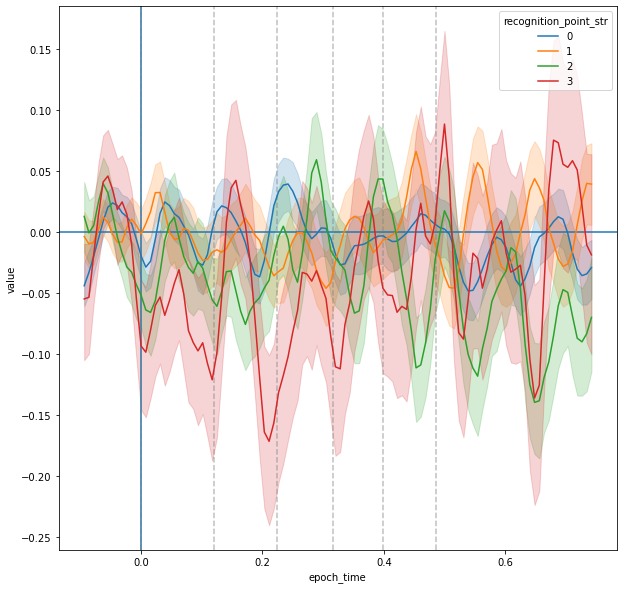

In [27]:
plt.subplots(figsize=(10, 10))
plt.axhline(0)
plt.axvline(0)
for phoneme_onset_i in ph_ons.nanmean(axis=0).numpy():
    if phoneme_onset_i > encoder.tmax:
        continue
    plt.axvline(phoneme_onset_i, color="gray", linestyle="--", alpha=0.5)

# Force categorical color scheme
rec_epoch_df_all["recognition_point_str"] = rec_epoch_df_all.recognition_point.astype(str)
sns.lineplot(data=rec_epoch_df_all, x="epoch_time", y="value", hue="recognition_point_str")

In [28]:
# g = sns.FacetGrid(data=rec_epoch_df_all.reset_index(), row="sensor", height=7, sharey=False)
# g.map(sns.lineplot, "epoch_time", "value", "recognition_point_str").add_legend()

In [29]:
# sns.lineplot(data=rec_epoch_df_all, x="epoch_time", y="value")

In [30]:
# rec_epoch_df_all.groupby(["recognition_point", "sensor"]).apply(lambda xs: xs.iloc[xs.value.argmin()].epoch_time)

### Show epoched data, indexed by recognition point

In [31]:
rec_epoch_reindex_df = {}
for ds_name, recognition_points_ds in tqdm(recognition_points.items()):
    word_ids = torch.arange(recognition_points_ds.shape[0])
    ds_i = next(iter(d for d in ds if d.name == ds_name))
    eeg_data = Y_resid_ablated[ds_name]

    rec_epoch_reindex_df[ds_name] = make_word_epochs(
        word_ids, ds_i.word_onsets, ds_i.phoneme_onsets,
        recognition_points_ds, eeg_data,
        index_by_recognition=True,
        baseline=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2190 [00:00<?, ?it/s]

  0%|          | 0/2118 [00:00<?, ?it/s]

In [32]:
rec_epoch_reindex_df = pd.concat(rec_epoch_reindex_df)# names=["dataset", "epoch", "sample" "sensor"])

In [33]:
rec_epoch_reindex_df

value  recognition_point  \
                    epoch sample sensor                                
DKZ_1/2019_C2DNN_29 0     0      C1      1.098073                  2   
                                 Cz      2.322764                  2   
                                 C2      1.543500                  2   
                                 CP1     2.341168                  2   
                                 CPz     1.936182                  2   
...                                           ...                ...   
DKZ_2/2019_C2DNN_29 2117  107    Cz      0.200880                  1   
                                 C2      0.949250                  1   
                                 CP1    -0.416166                  1   
                                 CPz     0.329644                  1   
                                 CP2     0.429084                  1   

                                         epoch_time  
                    epoch sample sensor              
DKZ_1/2019_C2DNN_29 0     0      C1       -0.093750  
                                 Cz       -0.093750  
                                 C2       -0.093750  
                                 CP1      -0.093750  
                                 CPz      -0.093750  
...                                             ...  
DKZ_2/2019_C2DNN_29 2117  107    Cz        0.742188  
                                 C2        0.742188  
                                 CP1       0.742188  
                                 CPz       0.742188  
                                 CP2       0.742188  

[2791584 rows x 3 columns]

In [34]:
rec_epoch_reindex_df.value.isna().sum()

630

Text(0, 0.5, 'Raw EEG residuals (avg over centroparietal sensors)')

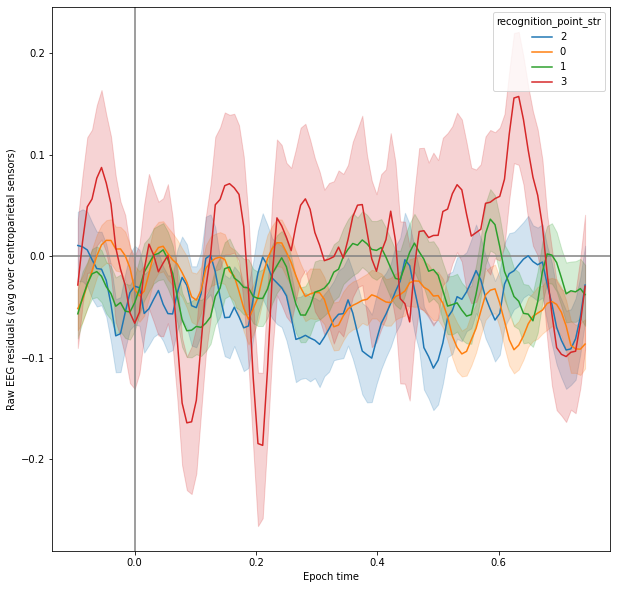

In [35]:
plt.subplots(figsize=(10, 10))
plt.axhline(0, color="gray")
plt.axvline(0, color="gray")

# Force categorical color scheme
rec_epoch_reindex_df["recognition_point_str"] = rec_epoch_reindex_df.recognition_point.astype(str)
sns.lineplot(data=rec_epoch_reindex_df[rec_epoch_reindex_df.recognition_point < 4],
             x="epoch_time", y="value", hue="recognition_point_str")
plt.xlabel("Epoch time")
plt.ylabel("Raw EEG residuals (avg over centroparietal sensors)")